In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, horizon=96)
df.to_pickle('/tmp/df_horizon96.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-04 09:00:00+00:00 ETH      1553.585714   1559.401429   1553.180000   
                          LINK        6.862059      6.922685      6.857853   
                          MATIC       0.878885      0.881786      0.877998   
                          SOL        31.301789     31.634706     31.297660   
                          XRP         0.329008      0.329788      0.328550   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-04 09:00:00+00:00 ETH      1553.277143 2022-09-04 10:00:00+00:00   
                          LINK        6.912186 2022-09-04 10:00:00+00:00   
                          MATIC       0.878622 2022-09-04 10:00:00+00:00   
                          SOL        31.542288 2022-09-04 10:00:00+00:00   
                          XRP         0.329240 2022-09-04 10:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB    -0.034296  
                          BTC    -0.071897  
                          ETH    -0.070389  
                          XRP    -0.044890  
2019-07-20 01:00:00+00:00 BNB    -0.076668  
...                                    ...  
2022-09-04 09:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[246243 rows x 6 columns]

In [10]:
from scipy.stats import norm
from functools import partial
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        self.max_data_sec = (7 + 4) * 24 * 60 * 60 # for predict script
        self.horizon = 96

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        # df['ret_rank'] = norm.ppf(0.5 + 0.95 * df['ret_rank'])
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        self._model = Ridge(fit_intercept=False, alpha=1e5)
        
        self._model.fit(df[features], df['ret_rank'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        def macdsignal(x, timeperiod=None):
            return talib.MACDEXT(x, fastperiod=int(timeperiod * 1.3), slowperiod=timeperiod * 3, signalperiod=i)[1]
        
        df['ln_cl'] = np.log(df['cl'])
        
        for i in [2, 4, 8, 24, 48, 72, 96, 120]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72, 96, 120]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

            # if i <= 24:
                # df['feature_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
            
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        for col in get_feature_columns(df):
            df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = norm.ppf(0.5 + 0.95 * df[col])
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        return df


def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.005765967257567617
std 0.03828818402685724
sharpe 0.150593907862621
max drawdown 0.6255801374852861
return with cost statistics
mean 0.004944010043600893
std 0.03829602134912935
sharpe 0.12909983516377202
max drawdown 0.6250201374852861


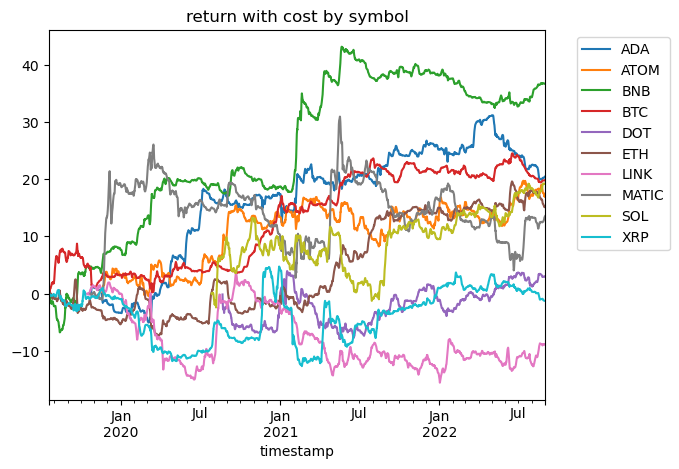

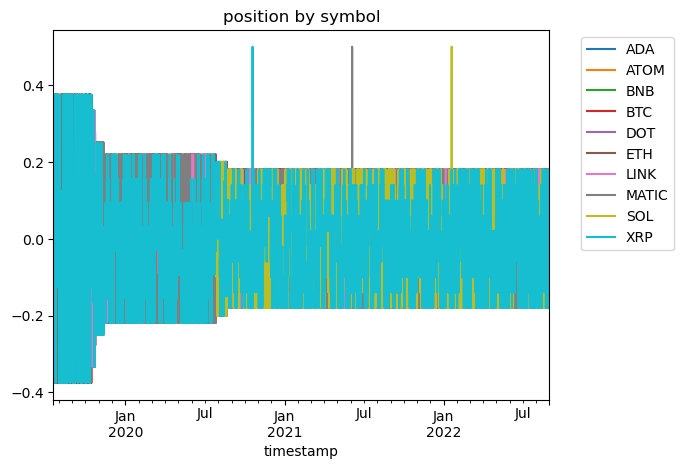

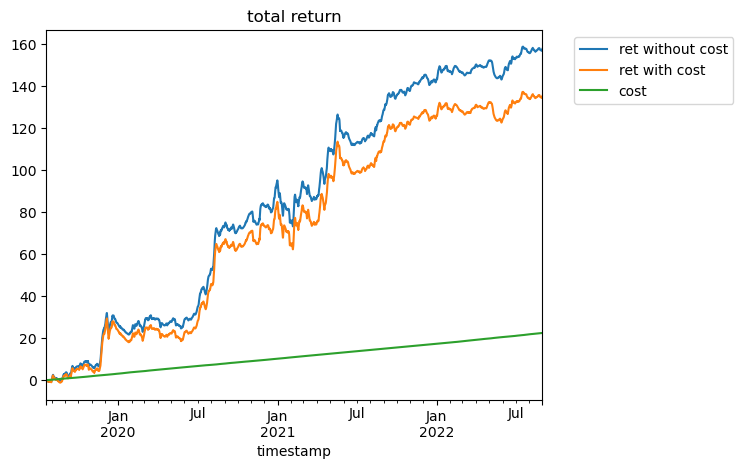

In [11]:
df = pd.read_pickle('/tmp/df_horizon96.pkl')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220904_ridge.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-08-24 09:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-04 09:00:00+00:00  ETH      -0.14
                           LINK      0.10
                           MATIC     0.06
                           SOL       0.02
                           XRP      -0.02
Name: position, Length: 2650, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-08-24 10:00:00+00:00 ADA     -0.055556  -0.055556       0.00
                          ATOM    -0.055556  -0.055556       0.00
                          BNB     -0.055556  -0.055556       0.00
                          BTC     -0.055556  -0.055556       0.00
                          DOT      0.500000   0.500000       0.00
...                                     ...        ...        ...
2022-09-04 08:00:00+00:00 ETH     -0.100000  -0.100000      -0.10
                          LINK     0.060000   0.060000       0.06
                          MATIC    0.100000   0.100000       0.10
                          SOL      0.020000   0.020000       0.02
                          XRP     -0.020000  -0.020000      -0.02

[2630 rows x 3 columns]

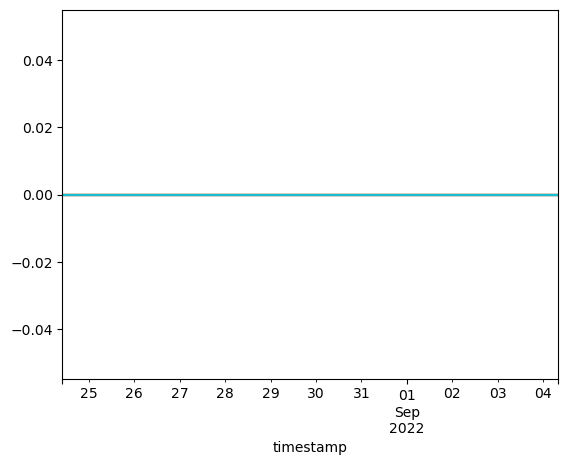

ADA (263, 4)
ATOM (263, 4)
BNB (263, 4)
BTC (263, 4)
DOT (263, 4)
ETH (263, 4)
LINK (263, 4)
MATIC (263, 4)
SOL (263, 4)
XRP (263, 4)


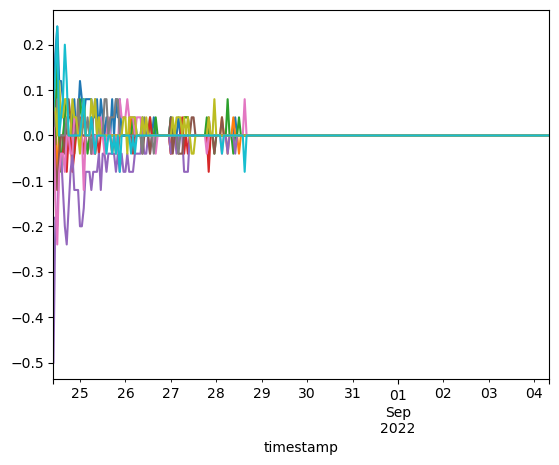

ADA (265, 3)
ATOM (265, 3)
BNB (265, 3)
BTC (265, 3)
DOT (265, 3)
ETH (265, 3)
LINK (265, 3)
MATIC (265, 3)
SOL (265, 3)
XRP (265, 3)


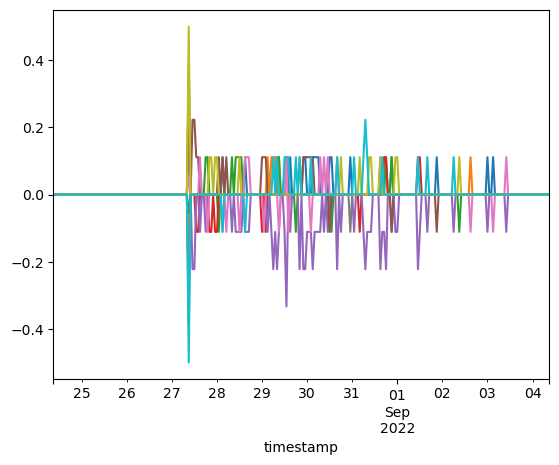

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220904_ridge.xz')
df = pd.read_pickle('/tmp/df_horizon96.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()